In [1]:
import logging
logger = logging.getLogger(__name__)
for system in ['h5py._conv', 'matplotlib', 'PIL']:
     logging.getLogger(system).setLevel(logging.WARNING)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
from dedalus import public as de

In [2]:
nz = 512
IC = 'LBVP' # 'LBVP' -> compute LBVP, 'linear' (or else) -> use linear ICs
verbose = True
q_surface = 1

In [3]:
Lx = Ly = 10
Lz = 1
Rayleigh = 1e6 #1e4
Prandtl = 1
Prandtlm = 1
#tau = 1e-2 #tau_Vallis*(Rayleigh*Prandtl)**(1/2)     #  condensation timescale

α = 3
β = 1.2 #1.201
γ = 0.19 #0.19
tau_Vallis = 5e-5
ΔT = -1

The non-dimensional tau timescale, relative to the thermal time, is:
\begin{equation}
    \tau = \tau_d \frac{\kappa}{H^2} = 5\times10^{-5}
\end{equation}
with $\tau_d$ the dimensional condensation time (Vallis et al 2019).

In buoyancy timescales,
\begin{align}
    \tau &= \tau_d \sqrt{\alpha \Delta T g} \\
    &= \tau_d \sqrt{\frac{\alpha \Delta T g H^4}{\kappa^2}} \frac{\kappa}{H^2} \\
    & = \sqrt{Ra Pr} \left(\tau_d \frac{\kappa}{H^2}\right) \\
    & = \sqrt{Ra Pr} \times \left(5\times10^{-5}\right) 
\end{align}
or, given $Ra \approx 10^{6}$
\begin{equation}
    \tau \approx 5 \times 10^{-3}
\end{equation}
This indicates that, in buoyancy time units, condensation is rapid compared to buoyant times.  Maybe too rapid.

Meanwhile, the quantity $P \tau$ is:
\begin{align}
    P \tau &= \frac{\sqrt{Ra Pr}}{\sqrt{Ra Pr}} \times \left(5\times10^{-5}\right) \\
    & = 5\times10^{-5}
\end{align}
Things probably don't get better if we multiply all terms through by P$\ldots$

In [4]:
P = (Rayleigh * Prandtl)**(-1/2)         #  diffusion on buoyancy
S = (Rayleigh * Prandtlm)**(-1/2)        #  diffusion on moisture

In [5]:
# Create bases and domain
coords = de.CartesianCoordinates('x', 'y', 'z')
dist = de.Distributor(coords, dtype=np.float64)
dealias = 2
zb = de.ChebyshevT(coords.coords[2], size=nz, bounds=(0, Lz), dealias=dealias)
z = zb.local_grid(1)

b = dist.Field(name='b', bases=zb)
q = dist.Field(name='q', bases=zb)

τb1 = dist.Field(name='τb1')
τb2 = dist.Field(name='τb2')
τq1 = dist.Field(name='τq1')
τq2 = dist.Field(name='τq2')

zb1 = zb.clone_with(a=zb.a+1, b=zb.b+1)
zb2 = zb.clone_with(a=zb.a+2, b=zb.b+2)
lift1 = lambda A, n: de.Lift(A, zb1, n)
lift = lambda A, n: de.Lift(A, zb2, n)

ex, ey, ez = coords.unit_vector_fields(dist)

k = 1e2 #3 #1e5 # cutoff for tanh
H = lambda A: 0.5*(1+np.tanh(k*A))

z_grid = dist.Field(name='z_grid', bases=zb)
z_grid['g'] = z

temp = b - β*z_grid
temp.name = 'T'

qs = np.exp(α*temp)
rh = q*np.exp(-α*temp)

tau = dist.Field(name='tau')

In [6]:
def plot_solution(solution, title=None, mask=None, linestyle=None, ax=None):
    b = solution['b']
    q = solution['q']
    m = solution['m']
    T = solution['T']
    rh = solution['rh']

    for f in [b, q, m, T, rh]:
        f.change_scales(1)
        
    if mask is None:
        mask = np.ones_like(z, dtype=bool)
    if ax is None:
        fig, ax = plt.subplots(ncols=2)
        markup = True
    else:
        for axi in ax:
            axi.set_prop_cycle(None)
        markup = False
    ax[0].plot(b['g'][mask],z[mask], label='$b$', linestyle=linestyle)
    ax[0].plot(γ*q['g'][mask],z[mask], label='$\gamma q$', linestyle=linestyle)
    ax[0].plot(m['g'][mask],z[mask], label='$b+\gamma q$', linestyle=linestyle)

    ax[1].plot(T['g'][mask],z[mask], label='$T$', linestyle=linestyle)
    ax[1].plot(q['g'][mask],z[mask], label='$q$', linestyle=linestyle)
    ax[1].plot(rh['g'][mask],z[mask], label='$r_h$', linestyle=linestyle)
    
    if markup:
        ax[1].legend()
        ax[0].legend()
        ax[0].set_ylabel('z')
        if title:
            ax[0].set_title(title)
    return ax

2022-10-19 09:17:36,679 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
b: 1.4e-17 -- 0.2
q: 1 -- 0.05


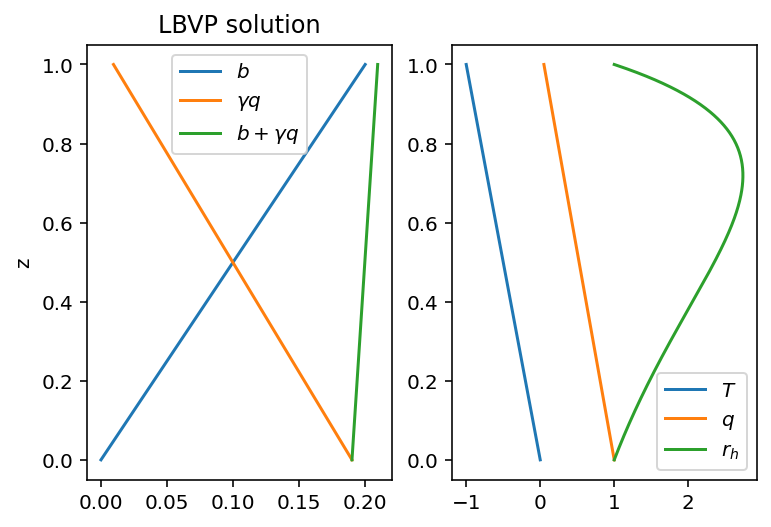

In [7]:
if IC == 'LBVP':
    dt = lambda A: 0*A
    # Stable linear solution as an intial guess
    problem = de.LBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
    problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = 0')
    problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = 0')
    problem.add_equation('b(z=0) = 0')
    problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
    problem.add_equation('q(z=0) = q_surface')
    problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')
    solver = problem.build_solver()
    solver.solve()
else:
    b['g'] = (β + ΔT)*z
    q['g'] = (1-z+np.exp(α*ΔT))
    
print('b: {:.2g} -- {:.2g}'.format(b(z=0).evaluate()['g'][0,0,0], b(z=Lz).evaluate()['g'][0,0,0]))
print('q: {:.2g} -- {:.2g}'.format(q(z=0).evaluate()['g'][0,0,0], q(z=Lz).evaluate()['g'][0,0,0]))

LBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate(), 'T':temp.evaluate(), 'rh':rh.evaluate()}
if verbose:
    plot_solution(LBVP_sol, title='LBVP solution')

In [8]:
dt = lambda A: 0*A

# Stable nonlinear solution
problem = de.NLBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = γ*H(q-qs)*(q-qs)/tau')
problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = - H(q-qs)*(q-qs)/tau')
problem.add_equation('b(z=0) = 0')
problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
problem.add_equation('q(z=0) = q_surface*qs(z=0)')
problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')

In [9]:
for system in ['subsystems']:
     logging.getLogger(system).setLevel(logging.WARNING)

NLBVP_library = {}
tau_f = np.log10(tau_Vallis*np.sqrt(Rayleigh))
# Relax on tau
for tau_i in np.logspace(np.log10(3/8), tau_f, num=4):
    tau['g'] = tau_i
    # Relax on k
    for i, k in enumerate([1e1, 1e3, 1e5]):
        solver = problem.build_solver()
        pert_norm = np.inf
        tol = 1e-2
        while pert_norm > tol:
            solver.newton_iteration()
            pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
            logger.info("tau = {:.1g}, k = {:.0g}, L2 err = {:.1g}".format(tau['g'][0,0,0], k, pert_norm))
        NLBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate(), 'T':temp.evaluate(), 'rh':rh.evaluate()}
        if i == 0:
            NLBVP_library[tau_i] = {}
        NLBVP_library[tau_i][k] = NLBVP_sol

2022-10-19 09:17:45,920 __main__ 0/1 INFO :: tau = 0.4, k = 1e+01, L2 err = 0.3
2022-10-19 09:17:48,326 __main__ 0/1 INFO :: tau = 0.4, k = 1e+01, L2 err = 0.008
2022-10-19 09:17:48,945 __main__ 0/1 INFO :: tau = 0.4, k = 1e+03, L2 err = 0.003
2022-10-19 09:17:49,491 __main__ 0/1 INFO :: tau = 0.4, k = 1e+05, L2 err = 0.0004
2022-10-19 09:17:50,038 __main__ 0/1 INFO :: tau = 0.2, k = 1e+01, L2 err = 0.0009
2022-10-19 09:17:50,662 __main__ 0/1 INFO :: tau = 0.2, k = 1e+03, L2 err = 5e-05
2022-10-19 09:17:51,229 __main__ 0/1 INFO :: tau = 0.2, k = 1e+05, L2 err = 2e-07
2022-10-19 09:17:51,801 __main__ 0/1 INFO :: tau = 0.1, k = 1e+01, L2 err = 0.0005
2022-10-19 09:17:52,421 __main__ 0/1 INFO :: tau = 0.1, k = 1e+03, L2 err = 2e-05
2022-10-19 09:17:53,032 __main__ 0/1 INFO :: tau = 0.1, k = 1e+05, L2 err = 3e-08
2022-10-19 09:17:53,679 __main__ 0/1 INFO :: tau = 0.05, k = 1e+01, L2 err = 0.0003
2022-10-19 09:17:54,344 __main__ 0/1 INFO :: tau = 0.05, k = 1e+03, L2 err = 6e-06
2022-10-19 0

In [10]:
NLBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate(), 'T':temp.evaluate(), 'rh':rh.evaluate()}

array([<AxesSubplot:title={'center':'NLBVP solution'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

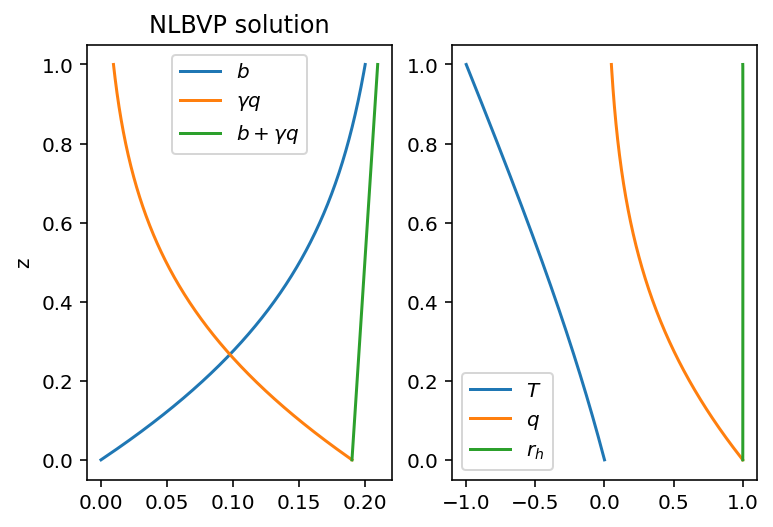

In [11]:
value = rh.evaluate()
value.change_scales(1)
mask = (value['g'] >= 1-0.01)
ax = plot_solution(NLBVP_sol, title='NLBVP solution', mask=mask, linestyle='solid')
mask = (value['g'] < 1-0.01)
plot_solution(NLBVP_sol, title='NLBVP solution', mask=mask, linestyle='dashed', ax=ax)

Text(0.5, 1.0, '$\\gamma$ = 0.19, $\\beta$ = 1.2, $\\tau$ = 0.05')

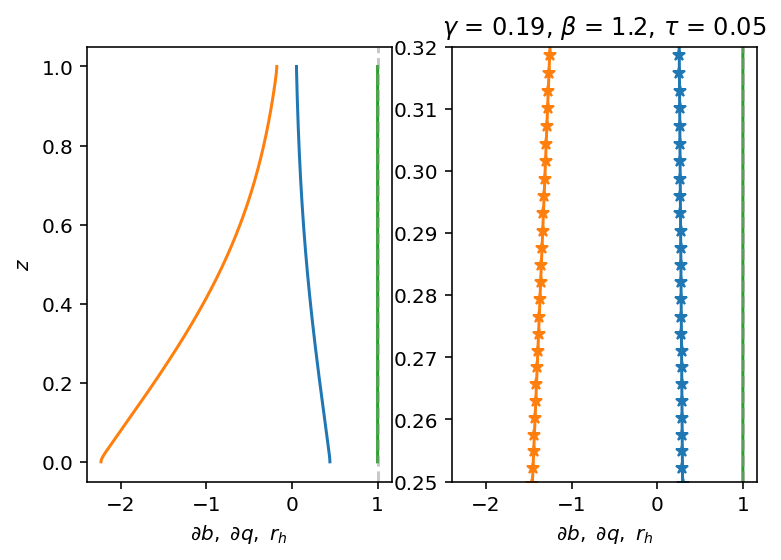

In [12]:
dz = lambda A: de.Differentiate(A, coords['z'])
dbdz = dz(NLBVP_sol['b']).evaluate()
dqdz = dz(NLBVP_sol['q']).evaluate()
dbdz.change_scales(1)
dqdz.change_scales(1)
NLBVP_sol['rh'].change_scales(1)
fig, ax = plt.subplots(ncols=2)
ax[0].plot(dbdz['g'][0,0,:], z[0,0,:])
ax[0].plot(dqdz['g'][0,0,:], z[0,0,:])
ax[0].plot(NLBVP_sol['rh']['g'][0,0,:], z[0,0,:])
ax[0].axvline(x=1, color='xkcd:grey', linestyle='dashed', alpha=0.5)
ax[0].set_xlabel('$\partial b,~\partial q,~r_h$')
ax[0].set_ylabel('$z$')
ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], marker='*')
ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], marker='*')
ax[1].plot(NLBVP_sol['rh']['g'][0,0,:], z[0,0,:])
ax[1].axvline(x=1, color='xkcd:grey', linestyle='dashed', alpha=0.5)
ax[1].set_ylim(0.25, 0.32)
ax[1].set_xlabel('$\partial b,~\partial q,~r_h$')
ax[1].set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\tau$ = {:.1g}'.format(γ,β, tau['g'][0,0,0]))

[0.375, 0.1915773580983883, 0.09787169102922161, 0.049999999999999996]


Text(0.5, 1.0, '$\\gamma$ = 0.19, $\\beta$ = 1.2, $\\tau$ = 0.05')

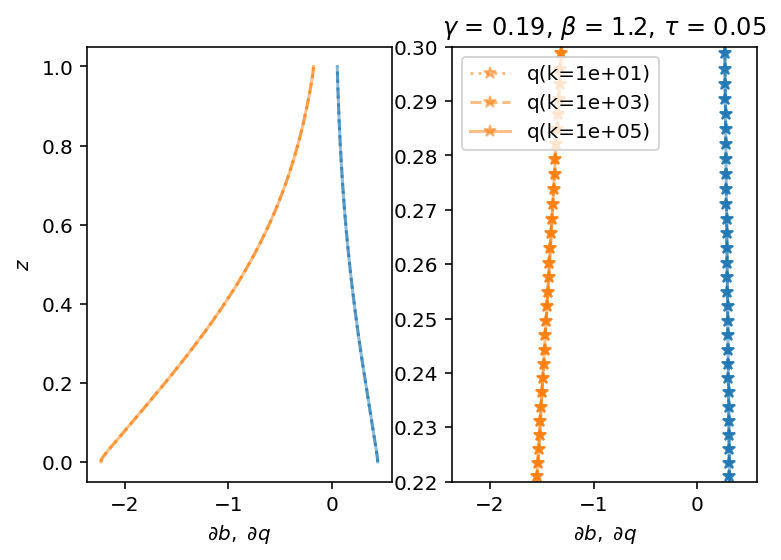

In [13]:
dz = lambda A: de.Differentiate(A, coords['z'])
taus = [k for k in NLBVP_library]
print(taus)
tau_i = taus[-1]
fig, ax = plt.subplots(ncols=2)
linestyles=['dotted', 'dashed', 'solid']
for i, k in enumerate(NLBVP_library[tau_i]):
    lib = NLBVP_library[tau_i]
    dbdz = dz(lib[k]['b']).evaluate()
    dqdz = dz(lib[k]['q']).evaluate()
    rh = lib[k]['rh']
    dbdz.change_scales(1)
    dqdz.change_scales(1)
    rh.change_scales(1)
    ax[0].plot(dbdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
    ax[0].plot(dqdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
    ax[0].set_xlabel('$\partial b,~\partial q$')
    ax[0].set_ylabel('$z$')
    ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], marker='*', alpha=0.5, linestyle=linestyles[i])#, label='b(k={:.1g})'.format(k))
    ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], marker='*', alpha=0.5, linestyle=linestyles[i], label='q(k={:.1g})'.format(k))
    ax[1].set_ylim(0.22, 0.30)
    ax[1].set_xlabel('$\partial b,~\partial q$')
    ax[0].set_prop_cycle(None)
    ax[1].set_prop_cycle(None)
ax[1].legend()
ax[1].set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\tau$ = {:.1g}'.format(γ,β, tau_i))

[0.375, 0.1915773580983883, 0.09787169102922161, 0.049999999999999996]


Text(0.5, 1.0, '$\\gamma$ = 0.19, $\\beta$ = 1.2, $\\tau$ = 0.4--0.05')

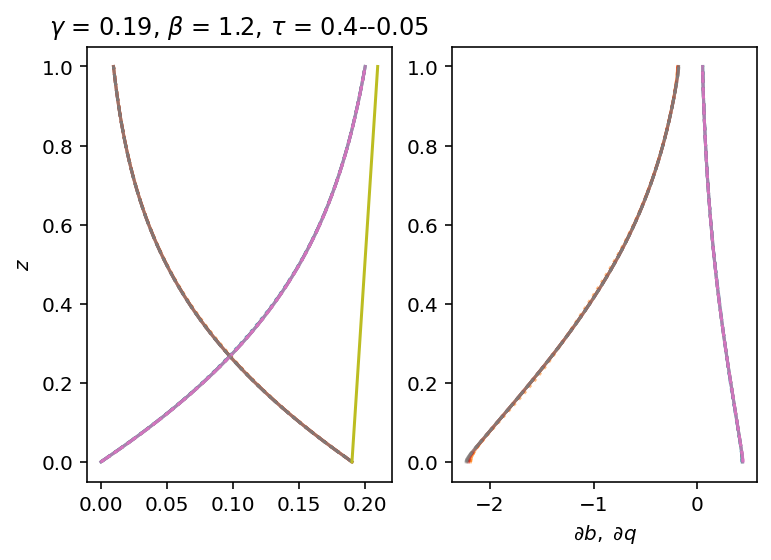

In [18]:
dz = lambda A: de.Differentiate(A, coords['z'])
taus = [k for k in NLBVP_library]
print(taus)
fig, ax = plt.subplots(ncols=2)
for tau_i in taus:
    linestyles=['dotted', 'dashed', 'solid']
    for i, k in enumerate(NLBVP_library[tau_i]):
        lib = NLBVP_library[tau_i]
        b = lib[k]['b']
        q = lib[k]['q']
        dbdz = dz(b).evaluate()
        dqdz = dz(q).evaluate()
        dbdz.change_scales(1)
        dqdz.change_scales(1)
        b.change_scales(1)
        q.change_scales(1)
        if i == 0:
            p1 = ax[0].plot(b['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
            p2 = ax[0].plot(γ*q['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])

            p1 = ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
            p2 = ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
        else:
            ax[0].plot(b['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p1[0].get_color())
            ax[0].plot(γ*q['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p2[0].get_color())
            ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p1[0].get_color())
            ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p2[0].get_color())

ax[0].plot(b['g'][0,0,:]+γ*q['g'][0,0,:], z[0,0,:])
ax[1].set_xlabel('$\partial b,~\partial q$')
ax[0].set_ylabel('$z$')
ax[0].set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\tau$ = {:.1g}--{:.1g}'.format(γ,β, taus[0], taus[-1]))

In [ ]:
print('diffusion timescale tau')
print('Vallis: {:.2g}'.format(tau_Vallis))
print('us:     {:.2g}'.format(tau['g'][0,0,0]*P))
print('buoyancy timescale tau')
print('Vallis: {:.2g}'.format(tau_Vallis/P))
print('us:     {:.2g}'.format(tau['g'][0,0,0]))


Analytic solutions
---------------------
For saturated atmospheres, we can construct an analytic function using Lambert W functions and following the discussion in section 5.1.

Things are a bit more complicated in a partially unsaturated atmosphere.  In that atmosphere, we need to construct a linear $q$ and $b$ profile until we hit $z_c$ where $q(z_c) = q_s(z_c)$, and then we proceed with the Lambert W solution.

Assume we start at $q(z=0) = q_0$ and $b(z=0)=b_0$, and that both $q$ and $b$ have linear profiles:
\begin{align}
    q(z) & = q_0 + Q z \\
    b(z) & = b_0 + B z \\
    T(z) & = b(z) - \beta z = b_0 + (B-\beta) z
\end{align}
They note that at $z=z_c$, $q$, $b$, $\partial_z q$ and $\partial_z b$ are all continuous, and this can be used (numerically) to solve for $z_c$.  Okay.

Meanwhile,
\begin{align}
q_s(z) = \exp{(\alpha T)} = \exp{(\alpha (b_0 + (B-\beta) z)}
\end{align}
and
\begin{align}
    q(z_c) &= q_s(z_c) \\
    q_0 + Q z_c &= \exp{(\alpha (b_0 + (B-\beta) z_c)}
\end{align}
We could rootfind on this for z_c if we knew $Q$ and $B$.  Hmm...


At $z_c$ we know:

from the bottom:
\begin{align}
b(z_c-) &= b_0 + B z_c \\
\partial b(z_c-) &= B
\end{align}
(whoa, B!=0, so that's inconsistent with 5.14, which said that $\partial b(z_c) = 0$)

oh, okay, (5.14) actually says:
\begin{align}
\partial q(z_c+) - \partial q(z_c-) = 0
\end{align}
ok!

And $T = b - \beta z$ (eq 4.9) so $b = T + \beta z$, and the upper solution is:
\begin{align}
T(z_c+) & = P + (Q-\beta) z_c+ - \frac{W(\alpha \gamma \exp(\alpha(P+(Q-\beta) z_c+)))}{\alpha}
\end{align}
or
\begin{align}
b(z_c+) & = P + Q z_c+ - \frac{W(\alpha \gamma \exp(\alpha(P+(Q-\beta) z_c+)))}{\alpha} \\
\partial b(z_c+) & = Q - \partial \frac{W(\alpha \gamma \exp(\alpha(P+(Q-\beta) z_c+)))}{\alpha}
\end{align}

Now, where are things complicated.

In [ ]:
from scipy.special import lambertw as W
def compute_analytic(z_in):
    z = dist.Field(bases=zb)
    z['g'] = z_in

    b1 = 0
    b2 = β + ΔT
    q1 = q_surface
    q2 = np.exp(α*ΔT)

    P = b1 + γ*q1
    Q = ((b2-b1) + γ*(q2-q1))
    
    C = P + (Q-β)*z['g']
    
    m = (P+Q*z).evaluate()
    T = dist.Field(bases=zb)
    T['g'] = C - W(α*γ*np.exp(α*C)).real/α
    b = (T + β*z).evaluate()
    q = ((m-b)/γ).evaluate()
    rh = (q*np.exp(-α*T)).evaluate()
    return {'b':b, 'q':q, 'm':m, 'T':T, 'rh':rh}

In [ ]:
analytic_sol = compute_analytic(z)
analytic_sol['rh'].change_scales(1)
mask = (analytic_sol['rh']['g'] >= 1)
ax = plot_solution(analytic_sol, title='Lambert W solution', mask=mask, linestyle='solid')
#mask = (analytic_solution['rh']['g'] < 1)
#plot_solution(solution=analytic_solution, mask=mask, linestyle='dashed', ax=ax)

In [ ]:
ax = plot_solution(NLBVP_sol, title='compare NLBVP (solid) vs W (dashed) solution', mask=mask, linestyle='solid')
plot_solution(analytic_sol, linestyle='dashed', ax=ax)
